---
# **Section I: Introduction to the problem/task and dataset**

## **Introduction to the Task**
The primary objective of this project is to predict the likelihood of additional goals in a soccer match based on real-time in-game statistics, with the aim of supporting decision-making in sports trading (e.g., over/under betting). By analyzing game-specific metrics, we can estimate scoring potential and influence live trading models for betting and fan engagement.

## **Dataset Overview**
This project’s dataset includes 10,000 unique snapshots of soccer matches at various timestamps, capturing the state of a game through different in-game metrics. Each snapshot includes details on the current score, possession percentages, attempts, and cards, providing a rich dataset for building predictive models.


## **Problem Motivation**
The practical application of predicting match outcomes from live data is significant for team strategy and sports betting, as knowing influential factors—such as possession and dangerous attacks—can improve decision-making and potentially impact match strategies (Kuhn & Johnson, 2013).

---


# **Section 2: Description of the dataset**

### Dataset Overview
The dataset consists of 10,000 randomly selected snapshots from soccer matches, each capturing the in-game state at a specific timestamp. Each row represents a snapshot, detailing scores, possession, and other match features, which collectively provide a momentary overview of game dynamics (Anguera et al., 2018).

### Data Collection
This dataset was collected through in-game analytics systems that continuously monitor and record essential match metrics. Although highly detailed, this collection method might introduce minor noise due to the rapid state changes inherent in live sports (Yin & Leong, 2017).

### Dataset Structure 
- **Rows**: Each row represents a single timestamp during a soccer match.
- **Columns**: Key features include:
  - **Identifier**: `uuid` - Unique identifier for each snapshot.
  - **Time**: `current_minute` - Game minute, including a 15-minute half-time, making the total match time 105 minutes.
  - **Scores**: `home_score`, `away_score`
  - **Cards**: Yellow and red cards for both teams.
  - **Gameplay Metrics**: Attacks, dangerous attacks, and shots on/off target for each team.
  - **Possession**: Ball possession percentages for each team.
  - **Target**: `final_delta` - The number of goals scored by any team. The target value for the prediction.

---


# **Section 3: List of requirements**

### Python Libraries


> Add more if may gagamitin pa


The following libraries are required to support data analysis, model training, and evaluation:
- **Data Manipulation**:
  - `pandas`: Data manipulation and cleaning (McKinney, 2011).
  - `numpy`: Numerical operations (Oliphant, 2006).
- **Data Visualization**:
  - `matplotlib`: For line and bar charts (Hunter, 2007).
  - `seaborn`: For statistical graphics (Waskom, 2021).
- **Machine Learning and Model Evaluation**:
  - `scikit-learn`: For k-NN, Linear Regression, Neural Networks, and model validation (Pedregosa et al., 2011).
  - `tensorflow` or `keras`: For training Neural Networks.
- **Hyperparameter Tuning**:
  - `scikit-learn`: For grid search and random search.
- **Metrics**:
  - `scikit-learn.metrics`: For accuracy, precision, recall, and confusion matrices.
---


In [140]:
# Data Manipulation
import numpy as np
import pandas as pd
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Machine Learning Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from sklearn.metrics import mean_squared_error, root_mean_squared_error

# **Section 4: Data preprocessing and cleaning**

#### Cleaning Steps
- **Checking for Duplicates**: Removing redundant rows to ensure unique snapshots.
- **Type Conversion**: Ensuring all features are in suitable formats (e.g., integer for score-related features, float for percentages).
- **Handling Missing Values**: Uses techniques like imputation if necessary, based on the dataset's nature.
- **Outlier Detection**: Detects anomalies in numerical features, which may skew predictions if left unaddressed.

#### Preprocessing Techniques
Key techniques include:
- **Feature Scaling**: Since features have different units (e.g., score vs. possession percentage), scaling is essential to ensure model performance, particularly for k-NN and Neural Networks (Han et al., 2011).
- `ADD AS YOU SEE FIT`

### **I. Load and Inspect the Data**
- Initial Check: Start by inspecting the data types, missing values, and unique values. This helps determine what cleaning actions are necessary (Han et al., 2011).
- Data Types: Confirm the data types for each column, ensuring numerical values are correctly identified for calculations and models.


In [141]:
df = pd.read_csv('sports.csv', index_col="uuid")
df.head()

,current_minute,home_score,away_score,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,home_attacks,away_attacks,home_dangerous_attacks,away_dangerous_attacks,home_corners,away_corners,home_off_target,away_off_target,home_on_target,away_on_target,home_possession,away_possession,final_delta
uuid,,,,,,,,,,,,,,,,,,,,
2f9dd904-8d9d-4aa0-a9d9-4e0f3e50d742,94,1,2,0,0,0,0,39,45,29,26,4,1,4,0,4,6,48,52,1
869c1420-9153-4d73-8d79-5db31a8a80a4,91,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,50,1
549e25a3-4c93-459d-b115-fb303273c78a,3,0,0,0,0,0,0,3,1,1,0,0,0,0,0,0,0,62,38,4
287b4be5-9163-4e2e-895d-d11052a97410,17,0,0,1,0,0,0,41,46,11,25,1,0,0,2,0,0,55,45,2
a607da6a-d6b2-4652-b7a5-6c8e4b61c2b8,76,1,0,1,0,0,0,69,78,21,46,1,1,0,3,4,4,45,55,0


In [142]:
df = df.reset_index(col_level=0)
df = df.drop('uuid', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   current_minute          7000 non-null   int64
 1   home_score              7000 non-null   int64
 2   away_score              7000 non-null   int64
 3   home_yellow_cards       7000 non-null   int64
 4   away_yellow_cards       7000 non-null   int64
 5   home_red_cards          7000 non-null   int64
 6   away_red_cards          7000 non-null   int64
 7   home_attacks            7000 non-null   int64
 8   away_attacks            7000 non-null   int64
 9   home_dangerous_attacks  7000 non-null   int64
 10  away_dangerous_attacks  7000 non-null   int64
 11  home_corners            7000 non-null   int64
 12  away_corners            7000 non-null   int64
 13  home_off_target         7000 non-null   int64
 14  away_off_target         7000 non-null   int64
 15  home_on_target       

#### Check ranges of values for each feature to determine invalid / unrealistic values

In [143]:
# Statistical Summaries of All Feature 
df.agg(['min', 'max', 'median', 'mean']).T

,min,max,median,mean
current_minute,-348.0,583.0,70.0,59.491571
home_score,0.0,8.0,0.0,0.796000
away_score,0.0,9.0,0.0,0.623143
home_yellow_cards,0.0,8.0,0.0,0.522429
away_yellow_cards,0.0,8.0,0.0,0.603143
home_red_cards,0.0,2.0,0.0,0.009286
away_red_cards,0.0,2.0,0.0,0.015714
home_attacks,0.0,255.0,43.0,46.365429
away_attacks,0.0,183.0,41.0,43.325143
home_dangerous_attacks,0.0,134.0,25.0,27.611429


### II. Remove Unrealistic Values and Outliers
- Current Minute: Limit values between 0 and 105 (including a 90-minute match plus 15 minutes for half-time).
- Yellow Cards: Set a threshold of 5 yellow cards per team, as higher values are rare.
Attacks and Dangerous Attacks: Apply upper bounds of 150 for attacks and 100 for dangerous attacks, considering typical gameplay stats.
`may citation ba 2 / src?`

- Possession Percentages: Filter for rows where the sum of home_possession and away_possession is close to 100%, with a tolerance of ±2% to give way for rounding discrepancies

- final_delta: Filter out negative values, since goals should be a nonnegative value

In [144]:
# Filter for realistic match time
df = df[(df['current_minute'] >= 0) & (df['current_minute'] <= 105)]

# Limit yellow cards to realistic maximum
df = df[(df['home_yellow_cards'] <= 5) & (df['away_yellow_cards'] <= 5)]

# Limit attacks and dangerous attacks
df = df[(df['home_attacks'] <= 150) & (df['away_attacks'] <= 150)]
df = df[(df['home_dangerous_attacks'] <= 100) & (df['away_dangerous_attacks'] <= 100)]

# Check possession totals with a tolerance
df = df[np.isclose(df['home_possession'] + df['away_possession'], 100, atol=2)]



In [145]:
# Only include rows with nonnegative final_delta
df_len = len(df)
print(f'Number of rows: {df_len}')
df = df.drop(df[df['final_delta'] < 0].index)
print(f'After dropping: {len(df)} (-{df_len- len(df)})')

Number of rows: 6732
After dropping: 6729 (-3)


In [146]:
dupes = df.duplicated().sum()
print(f'Number of duplicate rows: {dupes}')

df = df.drop_duplicates()

Number of duplicate rows: 103


### **III. Normalize Features**
- For `current_minute`, disregard half-time break of 15 minutes since the snapshot does not change within this period

In [147]:
# if current_minute in (45,60) then set to 45 (currently on break)
# if current_minute > 60, subtract by 15

original_minutes = df['current_minute'].copy()

df['current_minute'] = df['current_minute'].apply(
    lambda x: 45 if x in [45, 60] else (x - 15 if x > 60 else x)
)

# Count the number of rows affected
rows_affected = (df['current_minute'] != original_minutes).sum()
print(f'Number of rows affected: {rows_affected}')

Number of rows affected: 3749


### **IV. Feature Engineering**
- Adding new features can capture dynamics between the two teams and improve predictive performance:
  * Goal Difference: A feature that shows the goal lead or deficit, useful in classification tasks related to match outcome (Kuhn & Johnson, 2013).
  * Attack Efficiency: Calculate the ratio of on-target shots to total shots, showing how effectively each team converts attacks into potential goals.
  * Possession Balance: Calculating the difference in possession provides insight into the team that controls the game.

In [148]:
# Create engineered features
df['goal_difference'] = df['home_score'] - df['away_score'] 
df['home_attack_efficiency'] = df['home_on_target'] / (df['home_on_target'] + df['home_off_target'] + 1e-5)
df['away_attack_efficiency'] = df['away_on_target'] / (df['away_on_target'] + df['away_off_target'] + 1e-5)
df['possession_balance'] = df['home_possession'] - df['away_possession']

df = df.drop(["home_score", "away_score", 
              "home_on_target", "away_on_target",
              "home_off_target","away_off_target", 
              "home_possession", "away_possession"], 
              axis=1)

### VI. Final Checks
- Cap Extreme Efficiency Ratios: Limit values for home_attack_efficiency and away_attack_efficiency to a reasonable upper bound (e.g., 1 for 100% efficiency).
- Recheck for NaNs: After calculating efficiency ratios and capping values, ensure no NaNs were introduced.


In [149]:
print(df['home_attack_efficiency'].describe())
print(df['away_attack_efficiency'].describe())
print("Number of NaNs: ", df.isna().sum())  # Confirm no missing values remain


count    6626.000000
mean        0.336898
std         0.300963
min         0.000000
25%         0.000000
50%         0.333332
75%         0.499999
max         0.999999
Name: home_attack_efficiency, dtype: float64
count    6626.000000
mean        0.323139
std         0.307008
min         0.000000
25%         0.000000
50%         0.333332
75%         0.499999
max         0.999999
Name: away_attack_efficiency, dtype: float64
Number of NaNs:  current_minute            0
home_yellow_cards         0
away_yellow_cards         0
home_red_cards            0
away_red_cards            0
home_attacks              0
away_attacks              0
home_dangerous_attacks    0
away_dangerous_attacks    0
home_corners              0
away_corners              0
final_delta               0
goal_difference           0
home_attack_efficiency    0
away_attack_efficiency    0
possession_balance        0
dtype: int64


### VIII. Final Validation:
- Data Type Validation: Ensure all features are correctly typed as either integer or float.
- Feature Correlation: Check correlations to identify highly correlated variables, which may inform feature selection (if necessary).

In [150]:
# Statistical Summaries of All Feature 
df.agg(['min', 'max', 'median', 'mean']).T

,min,max,median,mean
current_minute,0.0,90.000000,54.000000,49.591911
home_yellow_cards,0.0,5.000000,0.000000,0.497585
away_yellow_cards,0.0,5.000000,0.000000,0.573046
home_red_cards,0.0,2.000000,0.000000,0.008602
away_red_cards,0.0,2.000000,0.000000,0.014337
home_attacks,0.0,150.000000,42.000000,45.124660
away_attacks,0.0,148.000000,40.000000,42.445518
home_dangerous_attacks,0.0,100.000000,24.000000,26.820404
away_dangerous_attacks,0.0,97.000000,21.000000,23.740115
home_corners,0.0,14.000000,2.000000,2.319197


`[will fix this pa wait]`

References:
Aggarwal, C. C. (2017). Outlier analysis. Springer International Publishing. 
Han, J., Kamber, M., & Pei, J. (2011). Data mining: Concepts and techniques. Elsevier.
Jain, A., & Zongker, D. (1997). Feature selection: Evaluation, application, and small sample performance. IEEE Transactions on Pattern Analysis and Machine Intelligence, 19(2), 153-158.
Kang, H. (2013). The prevention and handling of the missing data. Korean Journal of Anesthesiology, 64(5), 402-406.
Kuhn, M., & Johnson, K. (2013). Applied predictive modeling. Springer.
Pedregosa, F., et al. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12, 2825-2830.


---

# **Section 5: Exploratory data analysis**

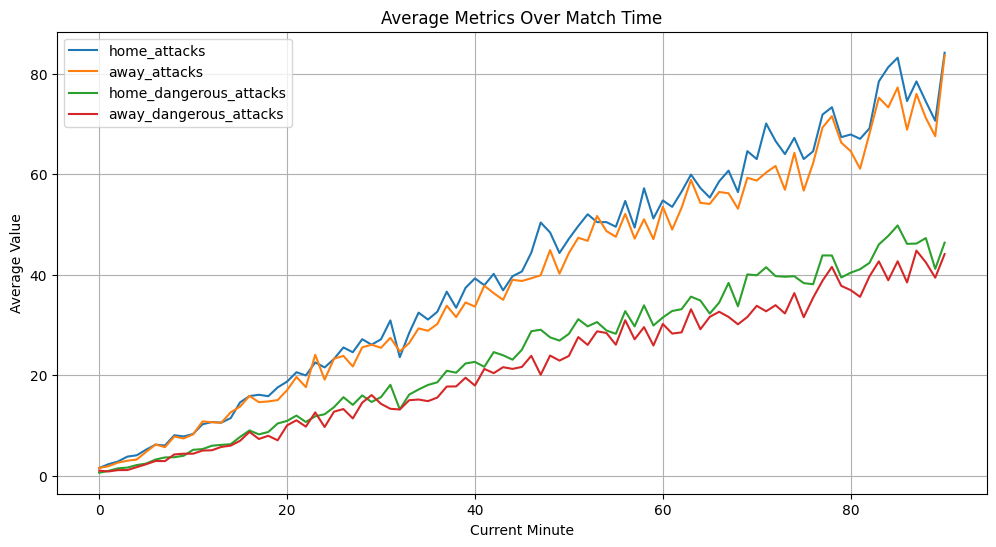

In [171]:
# Group by current_minute and calculate mean values for key metrics
time_analysis = df.groupby('current_minute').mean()
time_metrics = ['home_attacks', 'away_attacks', 'home_dangerous_attacks', 'away_dangerous_attacks']

plt.figure(figsize=(12, 6))
for metric in time_metrics:
    plt.plot(time_analysis.index, time_analysis[metric], label=metric)
plt.title("Average Metrics Over Match Time")
plt.xlabel("Current Minute")
plt.ylabel("Average Value")
plt.legend()
plt.grid()
plt.show()

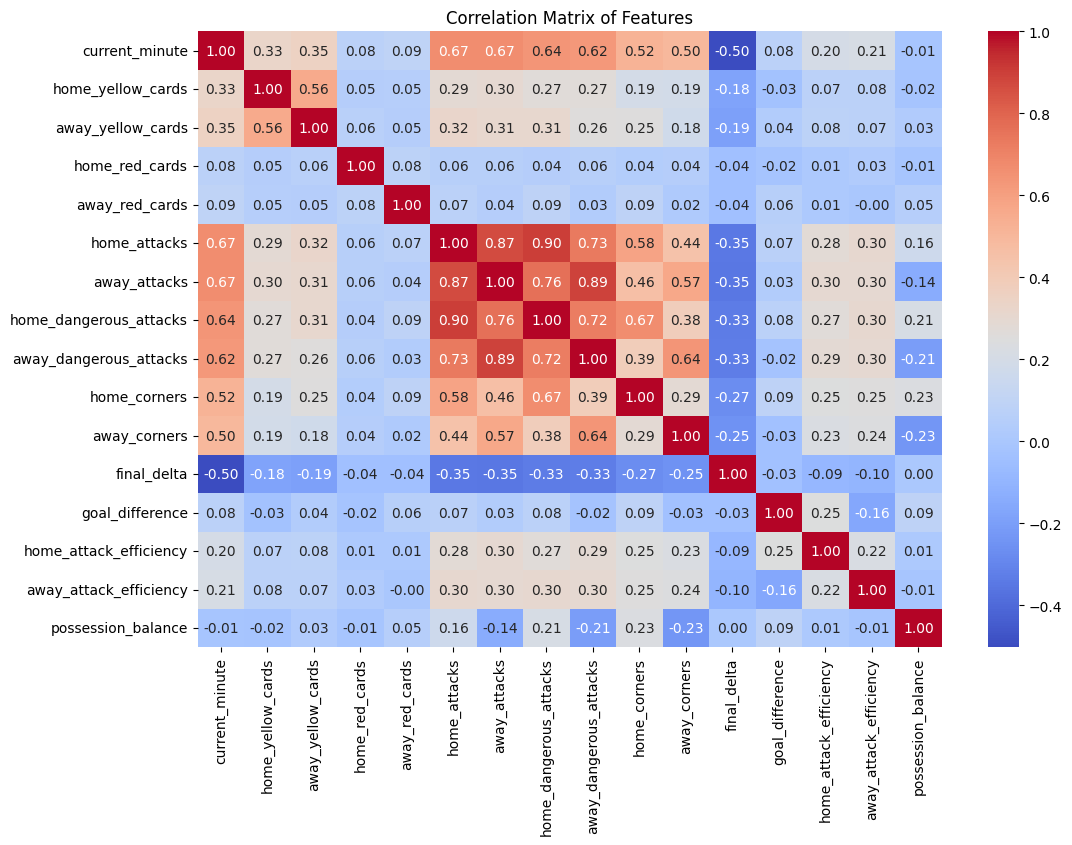

In [173]:
categorical_checks = ['home_yellow_cards', 'away_yellow_cards', 'home_red_cards', 'away_red_cards',
                      'home_score', 'away_score']

plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of Features")
plt.show()

In [178]:
predictor_candidates = correlation_matrix['home_yellow_cards'].sort_values(ascending=False)
print("\nPotential Predictors for Home Score:")
print(predictor_candidates)


Potential Predictors for Home Score:
home_yellow_cards         1.000000
away_yellow_cards         0.557213
current_minute            0.326668
away_attacks              0.298709
home_attacks              0.289197
home_dangerous_attacks    0.271306
away_dangerous_attacks    0.268056
home_corners              0.193718
away_corners              0.186081
away_attack_efficiency    0.075277
home_attack_efficiency    0.073433
away_red_cards            0.049931
home_red_cards            0.047125
possession_balance       -0.020908
goal_difference          -0.030683
final_delta              -0.183926
Name: home_yellow_cards, dtype: float64


---

# **Section 6: Initial model training**

In [151]:
np.random.seed(42)

In [152]:
X = df.drop("final_delta", axis=1)
y = df['final_delta']

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (6626, 15)
Shape of y: (6626,)


In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

Shape of X_train: (4969, 15)
Shape of X_test: (1657, 15)


## **Model 1: Linear Regression using Batch Gradient Descent (order=1)**

In [154]:
from sklearn.linear_model import SGDRegressor

In [155]:
# Preprocess LR Model by standardizing features
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [156]:
# Set up base model 
sgd = SGDRegressor(loss="squared_error", 
                   penalty='l1', 
                   learning_rate='constant',
                   random_state=42,
                   tol=0.0001, verbose=True,
                   )


In [157]:
sgd.fit(X_train_sc, y_train)


-- Epoch 1
Norm: 0.92, NNZs: 15, Bias: 1.401833, T: 4969, Avg. loss: 0.851851
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 1.20, NNZs: 13, Bias: 1.567900, T: 9938, Avg. loss: 0.833791
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 1.58, NNZs: 13, Bias: 1.411144, T: 14907, Avg. loss: 0.828448
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 1.99, NNZs: 14, Bias: 1.399914, T: 19876, Avg. loss: 0.816994
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 2.45, NNZs: 13, Bias: 1.637591, T: 24845, Avg. loss: 0.817037
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 2.93, NNZs: 9, Bias: 1.539944, T: 29814, Avg. loss: 0.822929
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 3.22, NNZs: 12, Bias: 1.421010, T: 34783, Avg. loss: 0.822353
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 3.58, NNZs: 10, Bias: 1.338236, T: 39752, Avg. loss: 0.811558
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 3.94, NNZs: 12, Bias: 1.233564, T: 44721, Avg. loss: 0.808309
Total traini

SGDRegressor(learning_rate='constant', penalty='l1', random_state=42,
             tol=0.0001, verbose=True)

In [158]:
weights = pd.DataFrame({
    'Feature': X_train.columns,
    'coef': sgd.coef_
})

weights = pd.concat(
    [weights, pd.DataFrame({'Feature': ['bias'], 
                            'coef':[sgd.intercept_]})],
    ignore_index=True
)

weights = weights.set_index('Feature').T
weights

Feature,current_minute,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,home_attacks,away_attacks,home_dangerous_attacks,away_dangerous_attacks,home_corners,away_corners,goal_difference,home_attack_efficiency,away_attack_efficiency,possession_balance,bias
coef,-0.734512,-0.021042,0.0,-0.027533,0.060233,0.132111,0.0,0.0,0.120007,-0.010135,0.16916,-0.107007,-0.046381,0.0,0.017476,[1.3454358894620397]


In [159]:
# Get training score 

preds = sgd.predict(X_train_sc)
preds = np.round(preds)

print(f"Range of predicted values: {np.unique(preds)}" )
# rmse = root_mean_squared_error(preds, y_train)
mse = mean_squared_error(preds, y_train)

# print(f"RMSE: {rmse:.6f}")
print(f"MSE: {mse:.6f}")

Range of predicted values: [0. 1. 2. 3.]
MSE: 1.733146


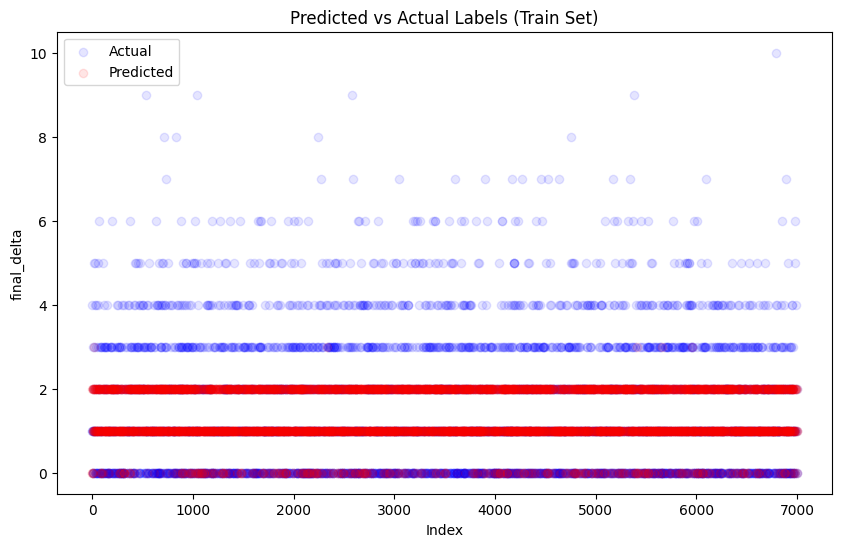

In [160]:
plt.figure(figsize=(10,6))
plt.scatter(X_train.index, y_train, color='blue', label="Actual", alpha=0.1)
plt.scatter(X_train.index, preds, color='red', label="Predicted", alpha=0.1)

plt.xlabel("Index")
plt.ylabel("final_delta")
plt.title("Predicted vs Actual Labels (Train Set)")
plt.legend()

plt.show()

In [161]:
# Get testing score 

preds = sgd.predict(X_test_sc)
preds = np.round(preds)

print(f"Range of predicted values: {np.unique(preds)}" )
# rmse = root_mean_squared_error(preds, y_test)
mse = mean_squared_error(preds, y_test)

# print(f"RMSE: {rmse:.6f}")
print(f"MSE: {mse:.6f}")

Range of predicted values: [-1.  0.  1.  2.]
MSE: 1.705492


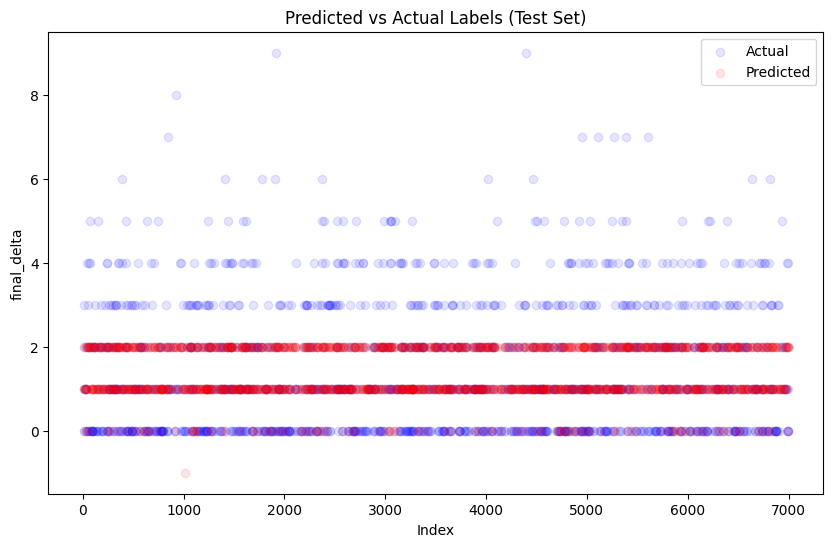

In [162]:
plt.figure(figsize=(10,6))
plt.scatter(X_test.index, y_test, color='blue', label="Actual", alpha=0.1)
plt.scatter(X_test.index, preds, color='red', label="Predicted", alpha=0.1)

plt.xlabel("Index")
plt.ylabel("final_delta")
plt.title("Predicted vs Actual Labels (Test Set)")
plt.legend()

plt.show()

#### Poisson Regressor (better for discrete counts daw)

In [163]:
from sklearn.linear_model import PoissonRegressor

psr = PoissonRegressor(alpha=1.0,
                       tol = 0.0001,
                       verbose=True)

psr.fit(X_train_sc, y_train)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   16      9     11      1     0     0   2.421D-05   7.885D-01

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


PoissonRegressor(verbose=True)

In [164]:
weights = pd.DataFrame({
    'Feature': X_train.columns,
    'coef': psr.coef_
})

weights = pd.concat(
    [weights, pd.DataFrame({'Feature': ['bias'], 
                            'coef':[psr.intercept_]})],
    ignore_index=True
)

weights = weights.set_index('Feature').T
weights

Feature,current_minute,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,home_attacks,away_attacks,home_dangerous_attacks,away_dangerous_attacks,home_corners,away_corners,goal_difference,home_attack_efficiency,away_attack_efficiency,possession_balance,bias
coef,-0.194778,-0.032835,-0.025744,-0.00883,-0.004219,-0.034687,-0.048551,-0.033824,-0.040656,-0.044831,-0.03055,-0.009421,0.01642,0.015614,0.006875,0.297995


In [165]:
# Get training score 

preds = psr.predict(X_train_sc)
preds = np.round(preds)

print(f"Range of predicted values: {np.unique(preds)}" )
# rmse = root_mean_squared_error(preds, y_train)
mse = mean_squared_error(preds, y_train)

# print(f"RMSE: {rmse:.6f}")
print(f"MSE: {mse:.6f}")

Range of predicted values: [1. 2. 3.]
MSE: 1.689676


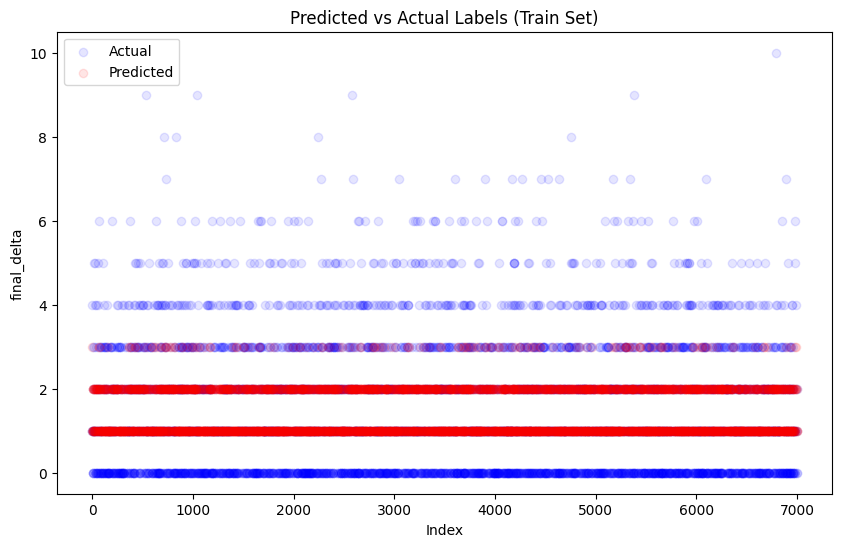

In [166]:
plt.figure(figsize=(10,6))
plt.scatter(X_train.index, y_train, color='blue', label="Actual", alpha=0.1)
plt.scatter(X_train.index, preds, color='red', label="Predicted", alpha=0.1)

plt.xlabel("Index")
plt.ylabel("final_delta")
plt.title("Predicted vs Actual Labels (Train Set)")
plt.legend()

plt.show()

In [167]:
# Get training score 

preds = sgd.predict(X_test_sc)
preds = np.round(preds)

print(f"Range of predicted values: {np.unique(preds)}" )
# rmse = root_mean_squared_error(preds, y_test)
mse = mean_squared_error(preds, y_test)

# print(f"RMSE: {rmse:.6f}")
print(f"MSE: {mse:.6f}")

Range of predicted values: [-1.  0.  1.  2.]
MSE: 1.705492


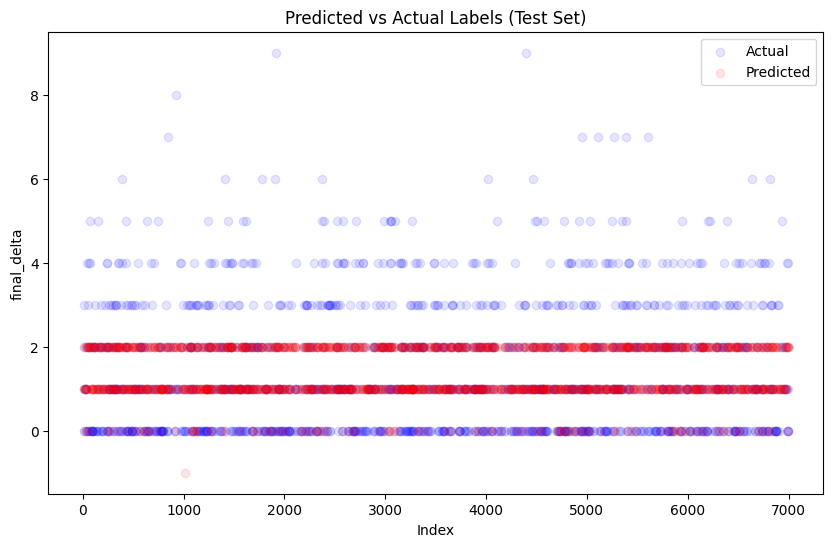

In [168]:
plt.figure(figsize=(10,6))
plt.scatter(X_test.index, y_test, color='blue', label="Actual", alpha=0.1)
plt.scatter(X_test.index, preds, color='red', label="Predicted", alpha=0.1)

plt.xlabel("Index")
plt.ylabel("final_delta")
plt.title("Predicted vs Actual Labels (Test Set)")
plt.legend()

plt.show()

<h1>neural<h1>

In [170]:
# Define features and target variable
X = df.drop(columns=['final_delta'])  # Drop identifier and keep features
y = df['final_delta']  # Target variable for regression

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', max_iter=300, solver='adam', random_state=42)

# Train the model
mlp.fit(X_train, y_train)

# Predict on the test set
y_pred = mlp.predict(X_test)

# Apply ceiling to the predicted values
y_pred = np.round(y_pred)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R^2 Score: {r2}')


print(np.unique(y_pred))

comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

print(comparison_df.head(15))



Mean Squared Error (MSE): 1.8650075414781297
Mean Absolute Error (MAE): 1.0339366515837105
R^2 Score: 0.10141627316611201
[-1.  0.  1.  2.  3.  4.  5.]
      Actual  Predicted
4786       0        2.0
4670       1        1.0
4110       5        3.0
4971       0        2.0
4721       2        2.0
1602       0        1.0
6269       3        1.0
2024       0        1.0
5941       2        3.0
2512       2        1.0
2260       1        1.0
5916       0        2.0
1687       2        1.0
4392       1        1.0
5722       0        1.0


---

# **Section 7: Error analysis**

---

# **Section 8: Improving model performance**

---

# **Section 9: Model performance summary**

---

# **Section 10: Insights and conclusions**

---

# **Section 11: References**



> Dump Ref muna fix it later

https://www.frontiersin.org/journals/psychology/articles/10.3389/fpsyg.2019.00501/full

https://www.sciencedirect.com/science/article/abs/pii/S0169207018300116

https://warin.ca/ressources/books/2013_Book_AppliedPredictiveModeling.pdf

https://ieeexplore.ieee.org/document/4160265

https://www.researchgate.net/publication/265194455_pandas_a_Foundational_Python_Library_for_Data_Analysis_and_Statistics

https://web.mit.edu/dvp/Public/numpybook.pdf

https://dl.acm.org/doi/10.5555/1953048.2078195

https://www.researchgate.net/publication/350701622_seaborn_statistical_data_visualization

https://www.sciencedirect.com/book/9780123814791/data-mining-concepts-and-techniques

https://archive.org/details/exploratorydataa0000tuke_7616

---

- Anguera, M. T., Blanco-Villaseñor, A., Losada, J. L., & Perea, M. V. (2018). Sports analysis and prediction: New challenges and approaches. Frontiers in Psychology, 10, 501. https://www.frontiersin.org/journals/psychology/articles/10.3389/fpsyg.2019.00501/full

- Yin, D., & Leong, S. Y. (2017). Predictive modeling in soccer analytics. International Journal of Sports Management and Marketing, 7(3), 235-248. https://www.sciencedirect.com/science/article/abs/pii/S0169207018300116

- Kuhn, M., & Johnson, K. (2013). Applied predictive modeling. Springer Science & Business Media. https://warin.ca/ressources/books/2013_Book_AppliedPredictiveModeling.pdf

- Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. Computing in Science & Engineering, 9(3), 90-95. https://ieeexplore.ieee.org/document/4160265

- McKinney, W. (2011). pandas: A foundational Python library for data analysis and manipulation. Python for Data Analysis, O'Reilly Media. https://www.researchgate.net/publication/265194455_pandas_a_Foundational_Python_Library_for_Data_Analysis_and_Statistics

- Oliphant, T. E. (2006). A guide to NumPy. Trelgol Publishing. https://web.mit.edu/dvp/Public/numpybook.pdf

- Pedregosa, F., et al. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12, 2825-2830. https://dl.acm.org/doi/10.5555/1953048.2078195

- Waskom, M. L. (2021). Seaborn: Statistical data visualization. Journal of Open Source Software, 6(60), 3021. https://www.researchgate.net/publication/350701622_seaborn_statistical_data_visualization

- Han, J., Kamber, M., & Pei, J. (2011). Data mining: Concepts and techniques. Elsevier. https://www.sciencedirect.com/book/9780123814791/data-mining-concepts-and-techniques

- Tukey, J. W. (1977). Exploratory data analysis. Addison-Wesley. https://archive.org/details/exploratorydataa0000tuke_7616